In [1]:
%load_ext autoreload
%autoreload 2

**<h2> Imports**

In [25]:
import numpy as np
import nibabel as nib
import sys
import os
from time import time, sleep
from scipy.ndimage import zoom
import matplotlib.pyplot as plt

<h4>import additional scripts:

In [26]:
from scripts.integral_volume import (Point3d, IntegralVol, IntegralVolTest)
from scripts.niblack3d import Niblack3d
from scripts.multyprocess_utils import MultuProcCalc
from scripts.load_dcm import get_dcm_info, get_dcm_vol, vox_size2affine, save_vol_as_nii

<h4> Show efficiency

In [24]:
IntegralVolTest()

preprocess time 0.6393992900848389
numpy time 4.86591362953186
integral vol time 0.0010232925415039062
calculation error: 3.259629011154175e-09


**<h2>Load Data**

**<h4> DICOMDIR**

In [5]:
path_to_dcm = '/home/msst/Documents/medtech/KT/S28050/S5020/'
dcm_data = get_dcm_info(path_to_dcm)
dcm_data.keys()

dict_keys(['ax 0.9 mm, iDose (4)'])

In [6]:
data = dcm_data['ax 0.9 mm, iDose (4)']
#data['file_names']

In [7]:
sorted_names = sorted(data['file_names'],
                      key=lambda item: (int(item[1:])))
data['file_names'] = sorted_names

In [8]:
brain_vol, vox_size = get_dcm_vol(path_to_dcm, data)
print(brain_vol.shape)

(512, 512, 372)


**<h4> NIFTI**

In [11]:
path_to_openneuro = "data/sub-299_ses-20110422_desc-angio_N4bfc_brain_mask.nii.gz"
path_to_nitr = "data/BH0020.nii.gz"
brain_file = nib.load(path_to_openneuro)

brain_vol = np.array(brain_file.dataobj)
print(brain_vol.shape)

(512, 512, 140)


In [12]:
##compressed
#brain_vol = zoom(brain_vol, (0.25, 0.25, 0.5))
#print(brain_vol.shape)

<h4> Padding

In [9]:
new_vol = np.zeros((brain_vol.shape[0], brain_vol.shape[1], brain_vol.shape[2]+20))
new_vol[:, :, 10:brain_vol.shape[2]+10] = brain_vol
brain_vol = new_vol

In [10]:
def print_img(vol, axis, title= 'title', slice=None, cmap='hot'):
    global SHOW_SLICE
    axis.set_title(title)
    if slice is None:
        im = axis.imshow(vol[:, :, SHOW_SLICE], cmap=cmap)
    else: 
        im = axis.imshow(vol[:, :, slice], cmap=cmap)
    plt.colorbar(im)

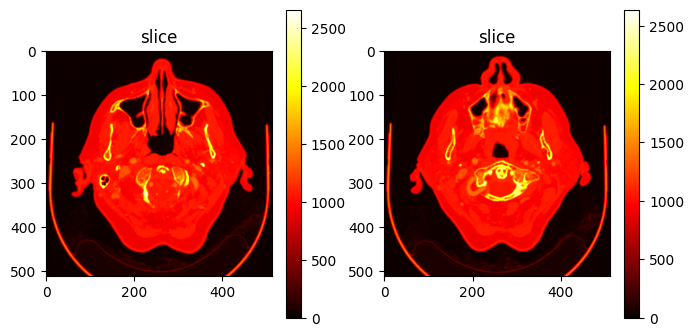

In [11]:
SHOW_SLICE = 31

fig, ax = plt.subplots(1, 2, figsize=(8, 4))    
print_img(brain_vol, ax[0], 'slice', 50)    
print_img(brain_vol, ax[1], 'slice')  

In [12]:
def create_hist(data, bins=1000):
    hist = np.histogram(data, bins, range=(data.min(), data.max()))
    counts, bins = hist
    return(counts, bins)

def plot_hist(counts, bins, range, bins_count=None, title="Graph"):
    plt.subplots(figsize=(4, 2)) 
    plt.hist(bins[:-1], bins_count, weights=counts, range=range)
    plt.title(title)
    plt.show()

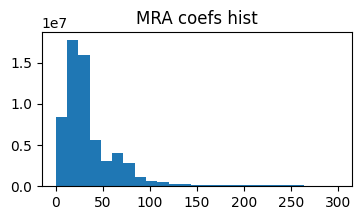

In [13]:
data = brain_vol
counts, bins = create_hist(data, 1000)
plot_hist(counts, bins, (data.min(), 300), 25, "MRA coefs hist")

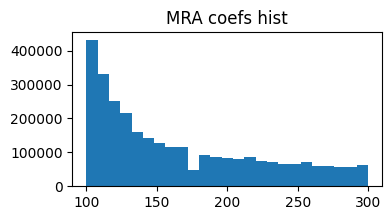

In [14]:
plot_hist(counts, bins, (100, 300), 25, "MRA coefs hist")

**<h2> Binarization**

<h4> Research dispersion

In [105]:
window_size = (25, 25, 9)
coef_k = 1
coef_a = 100
Niblack = Niblack3d(vol=brain_vol,
                    window_size=window_size,
                    coef_k=coef_k, 
                    coef_a=coef_a)

In [106]:
test_edges = [[100, 400],
                [100, 400],
                [100, 300]]
sigmas = Niblack.binarize(edges=test_edges, return_sigma=True)

In [117]:
sigmas = np.array(sigmas)
mu = sigmas[:, 0]
sigma = sigmas[:, 1]

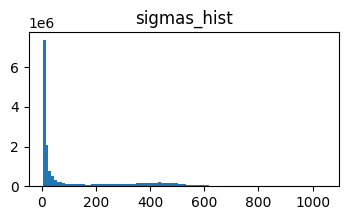

In [118]:
data = sigma
counts, bins = create_hist(data)
plot_hist(counts, bins, (data.min(), data.max()), 100, "sigmas_hist")

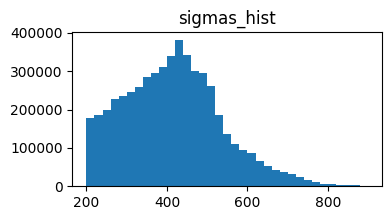

In [122]:
plot_hist(counts, bins, (200, 900), 35, "sigmas_hist")

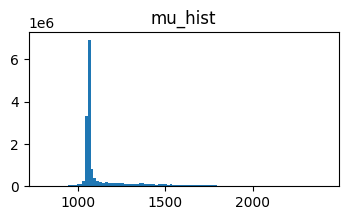

In [124]:
data = mu
counts, bins = create_hist(data)
plot_hist(counts, bins, (800, data.max()), 100, "mu_hist")

In [125]:
mu_agg = mu*1
mu_agg[mu_agg<0.000001] = 0.000001 #cut low mu
one_over_mu = 1/mu_agg 
mu_thresh = 100
one_over_mu[one_over_mu>1/mu_thresh] = 0 #cut low mu
sigma_over_high_mu = sigma * one_over_mu

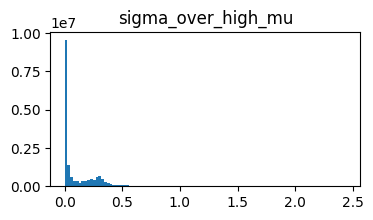

In [126]:
data = sigma_over_high_mu
counts, bins = create_hist(data, 1000)
plot_hist(counts, bins, (data.min(), data.max()), 100, "sigma_over_high_mu")

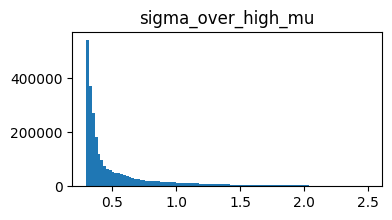

In [129]:
plot_hist(counts, bins, (0.3, 2.5), 100, "sigma_over_high_mu")

<h4> Calculations

In [15]:
window_size = (15, 15, 15)
coef_k = 0.5
coef_a = 50
Niblack = Niblack3d(vol=brain_vol,
                    window_size=window_size,
                    coef_k=coef_k, 
                    coef_a=coef_a,
                    thresh=(1080, 1800))

Calculator = MultuProcCalc(Niblack, num_workers=8)

In [16]:
start = time()
bin_vol = Calculator.run()
print("spend:", time() - start)

spend: 94.027268409729


<h4> Сколько тут сосудов?

In [17]:
bin_vol.sum()/(bin_vol.shape[0]*bin_vol.shape[1]*bin_vol.shape[2])

0.02077686543367347

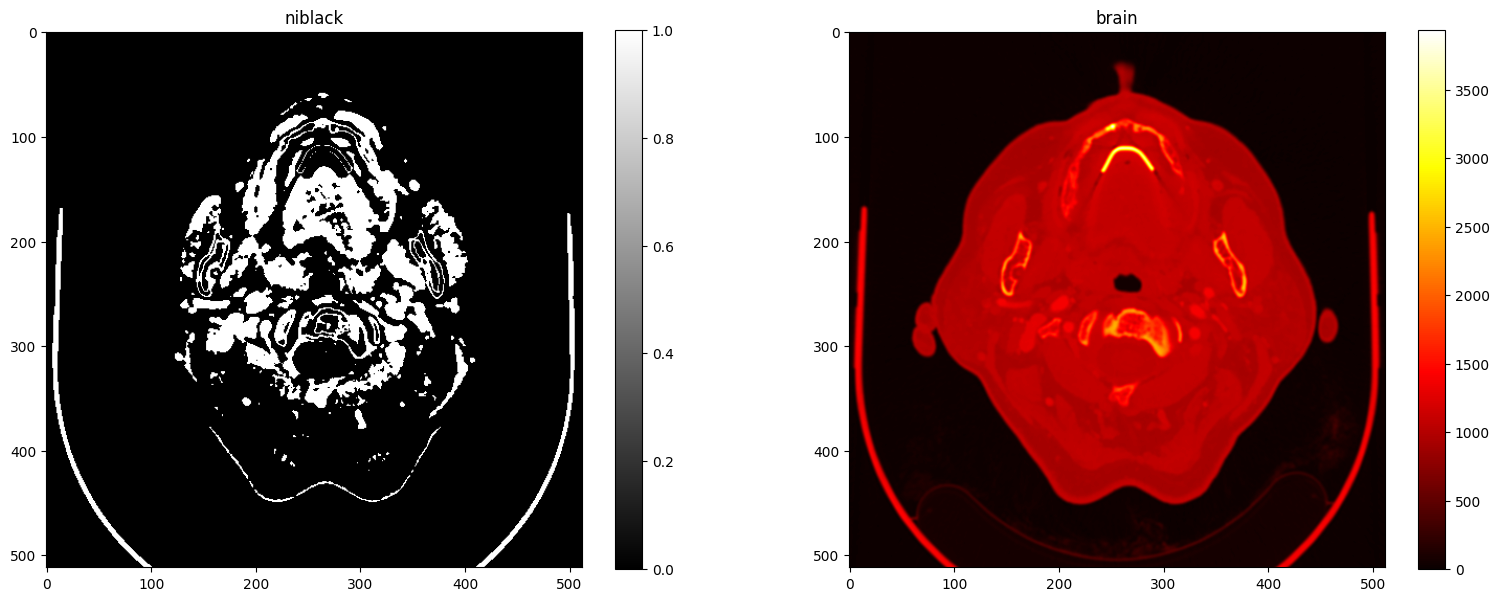

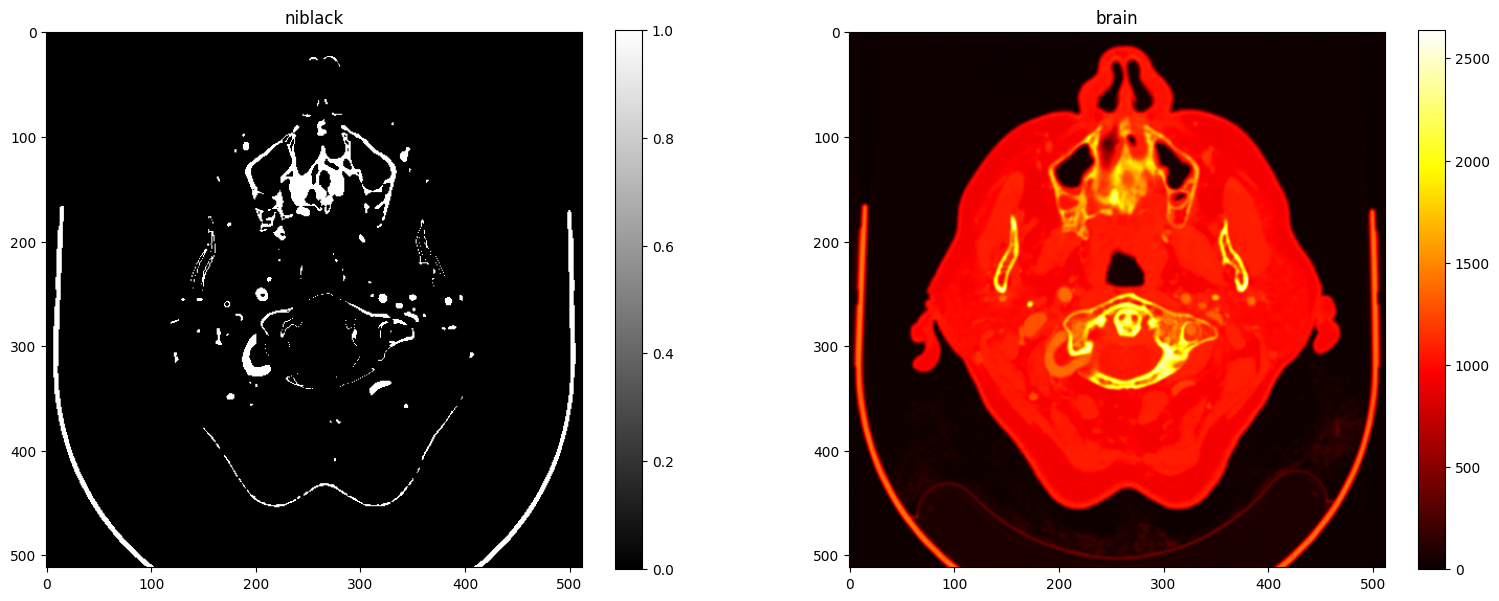

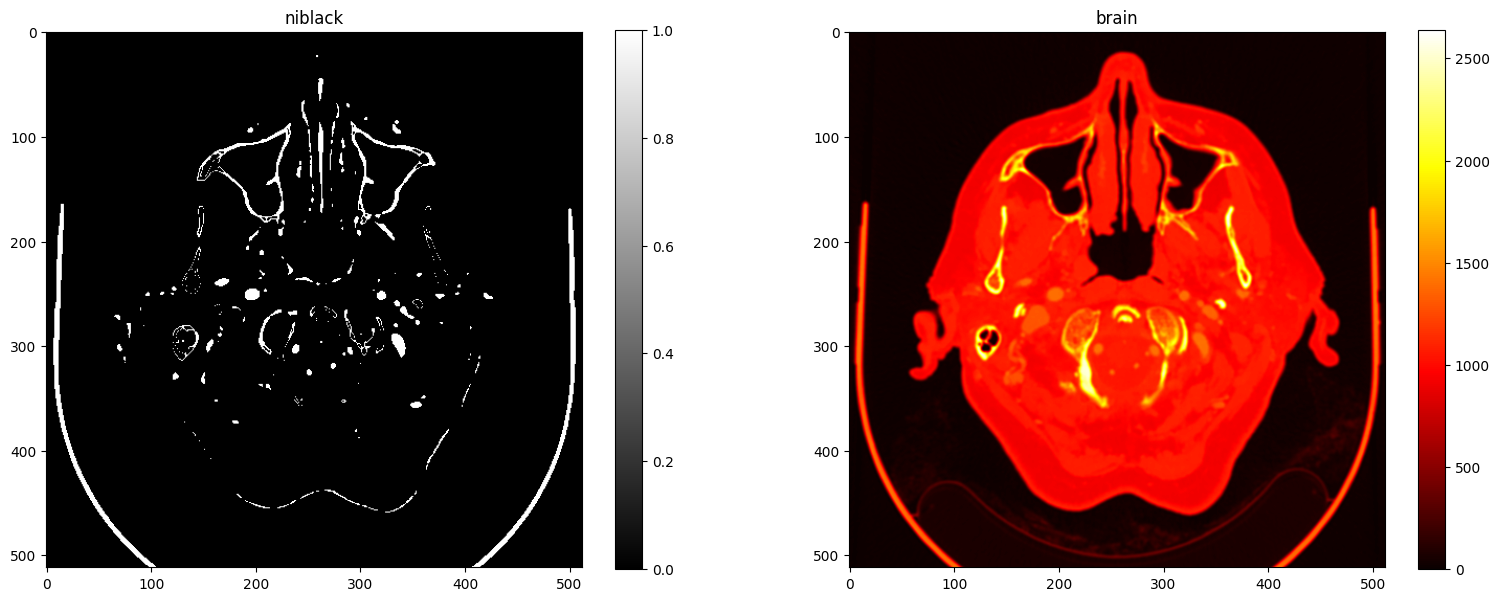

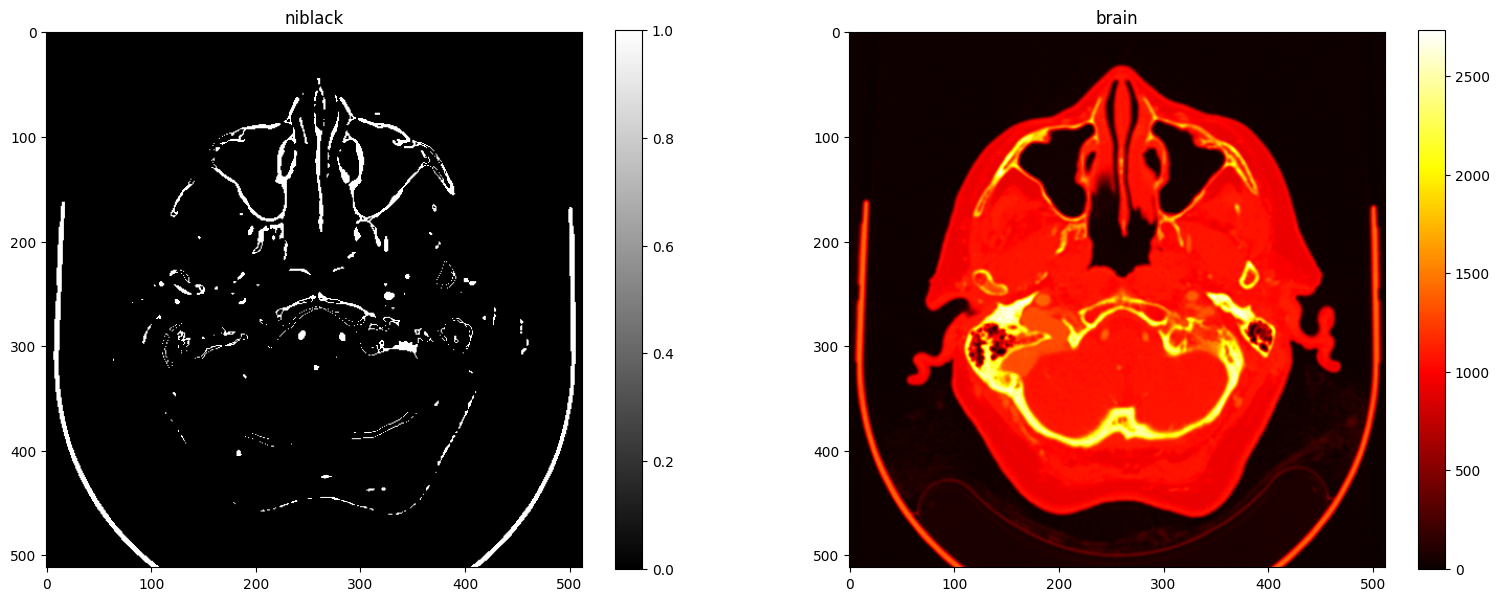

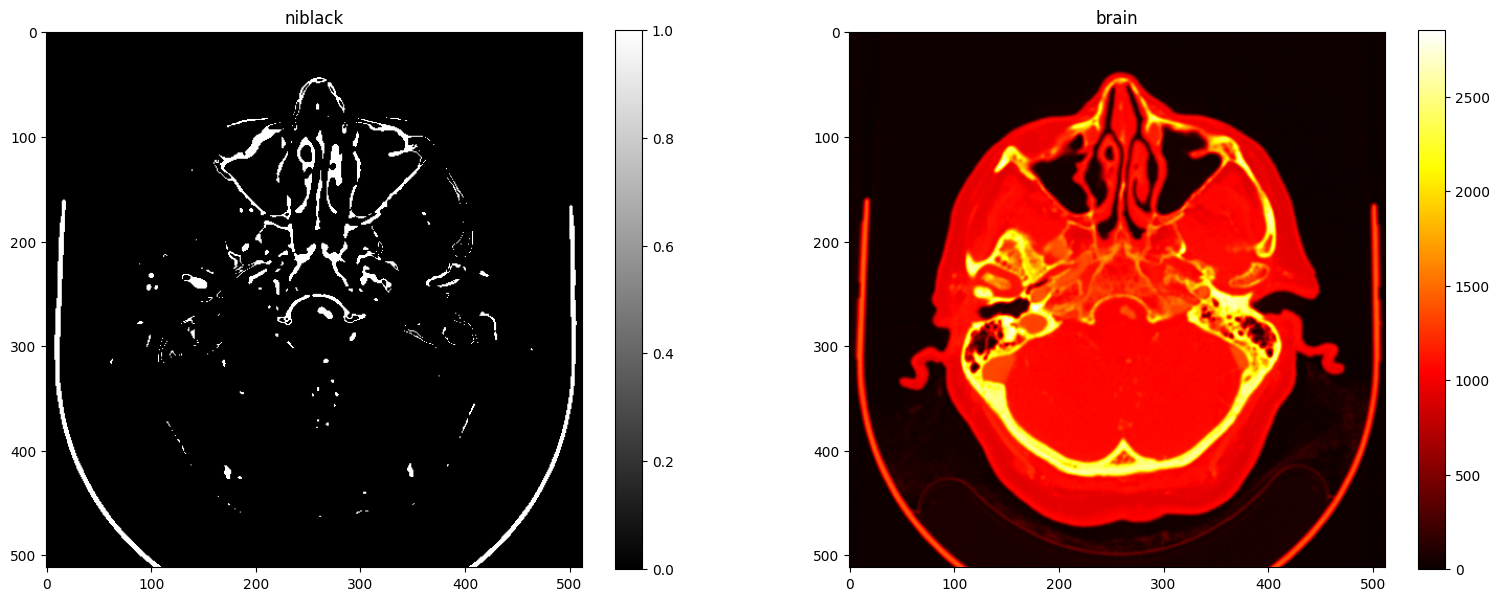

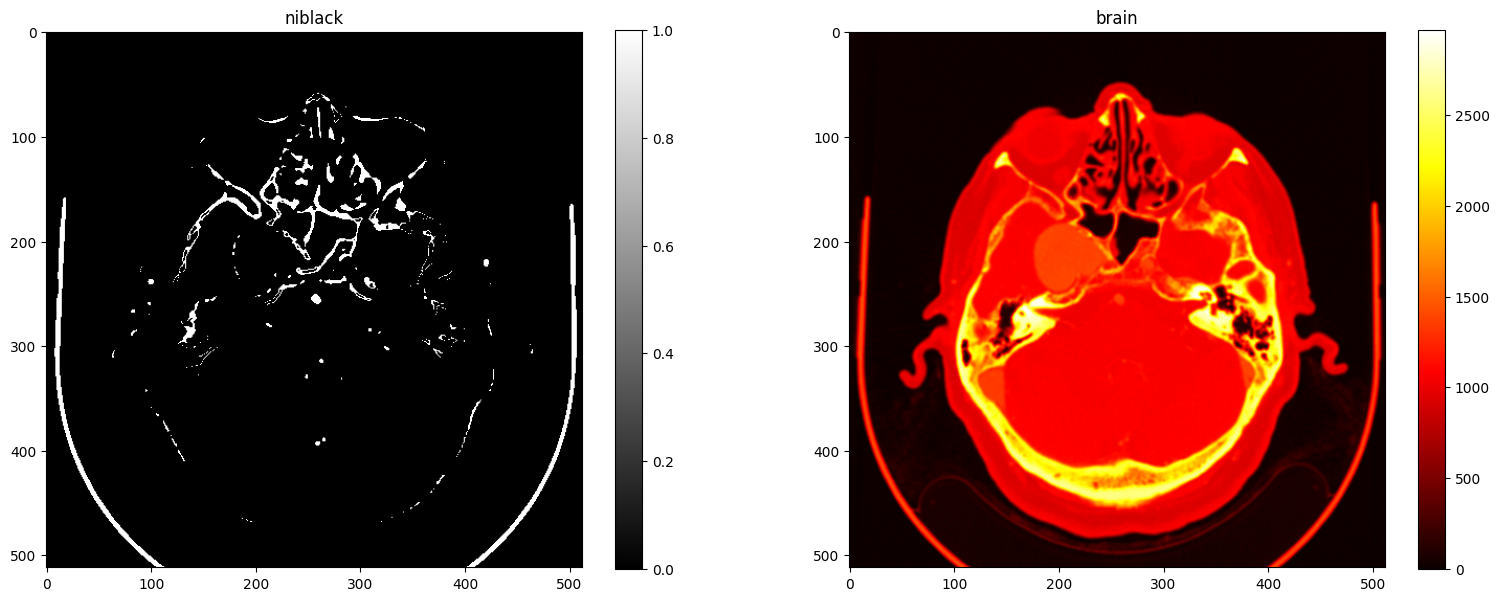

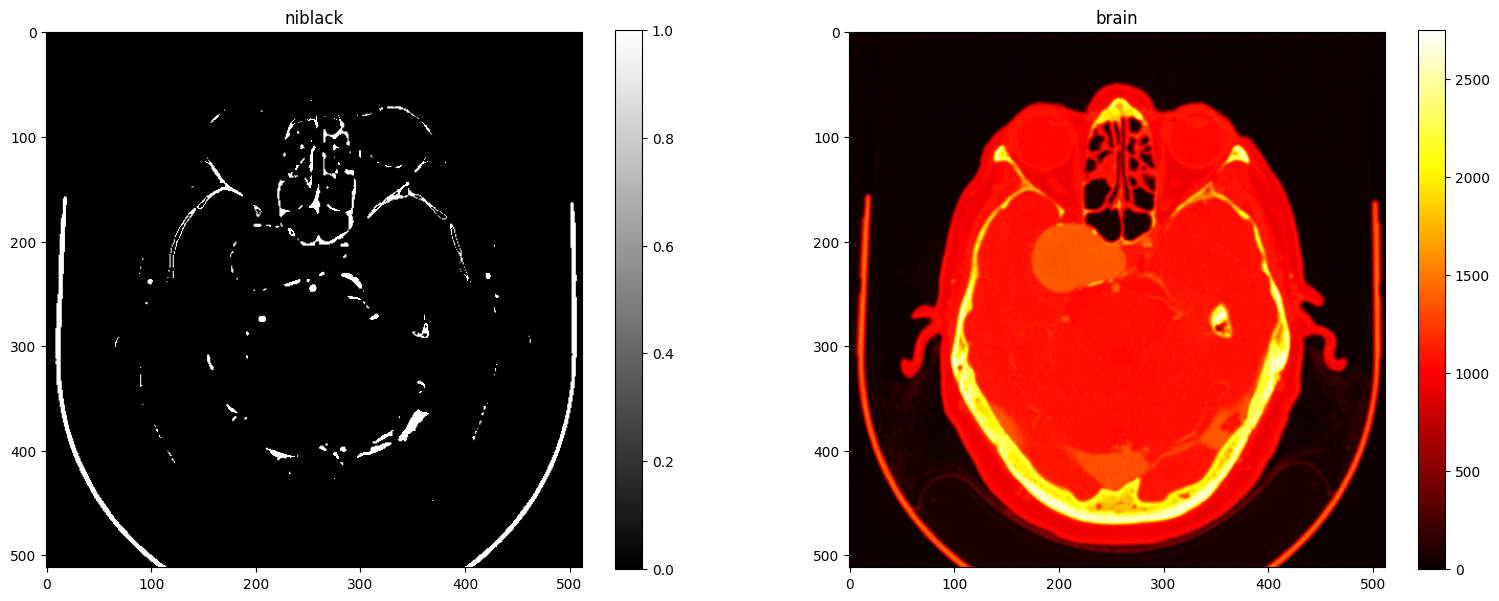

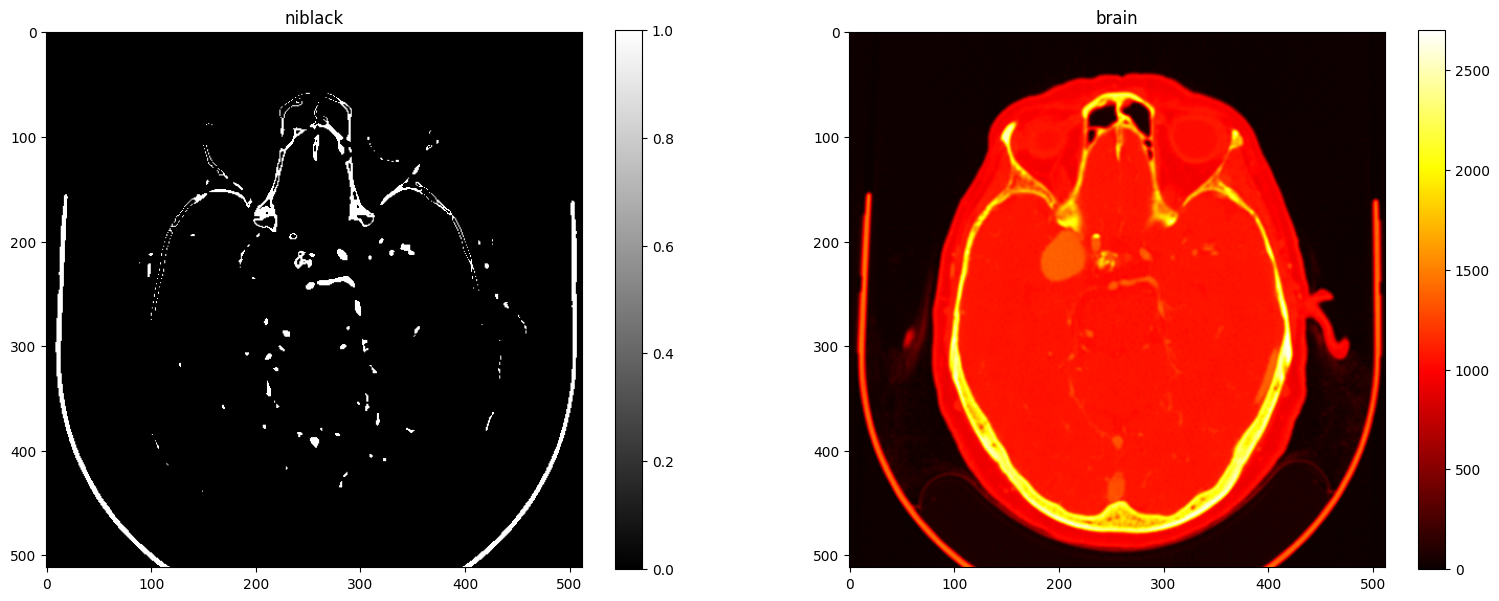

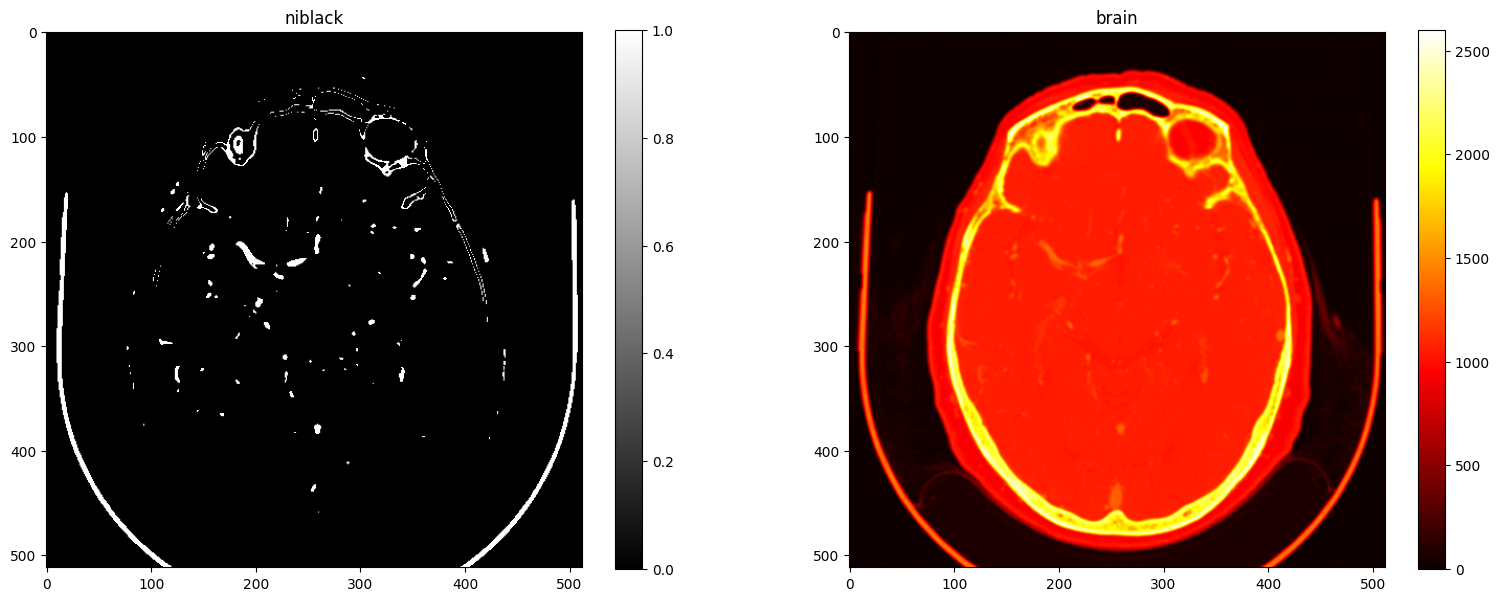

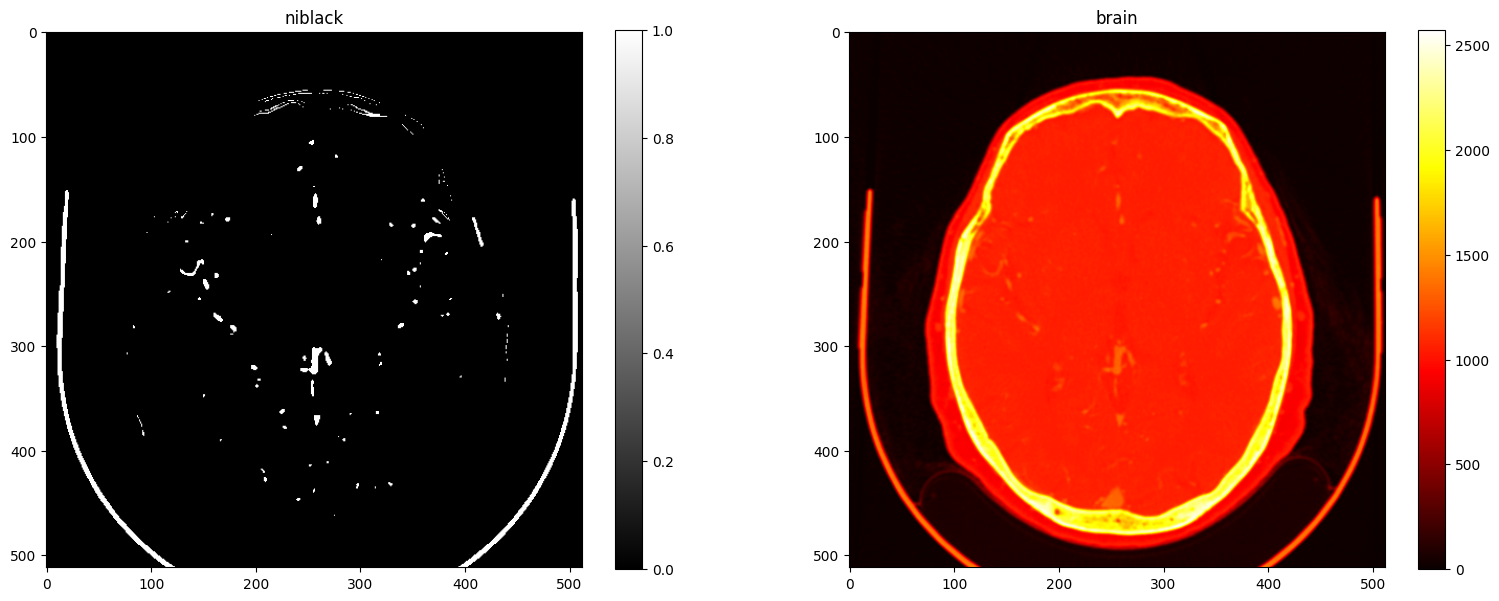

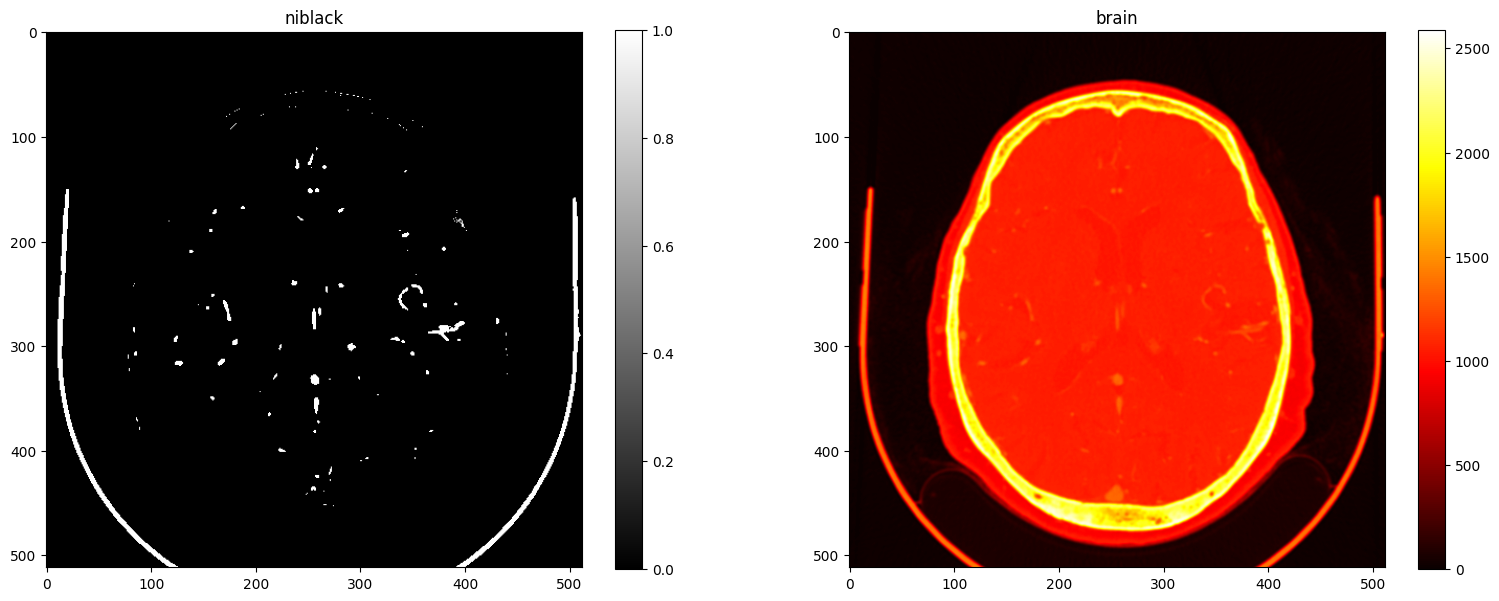

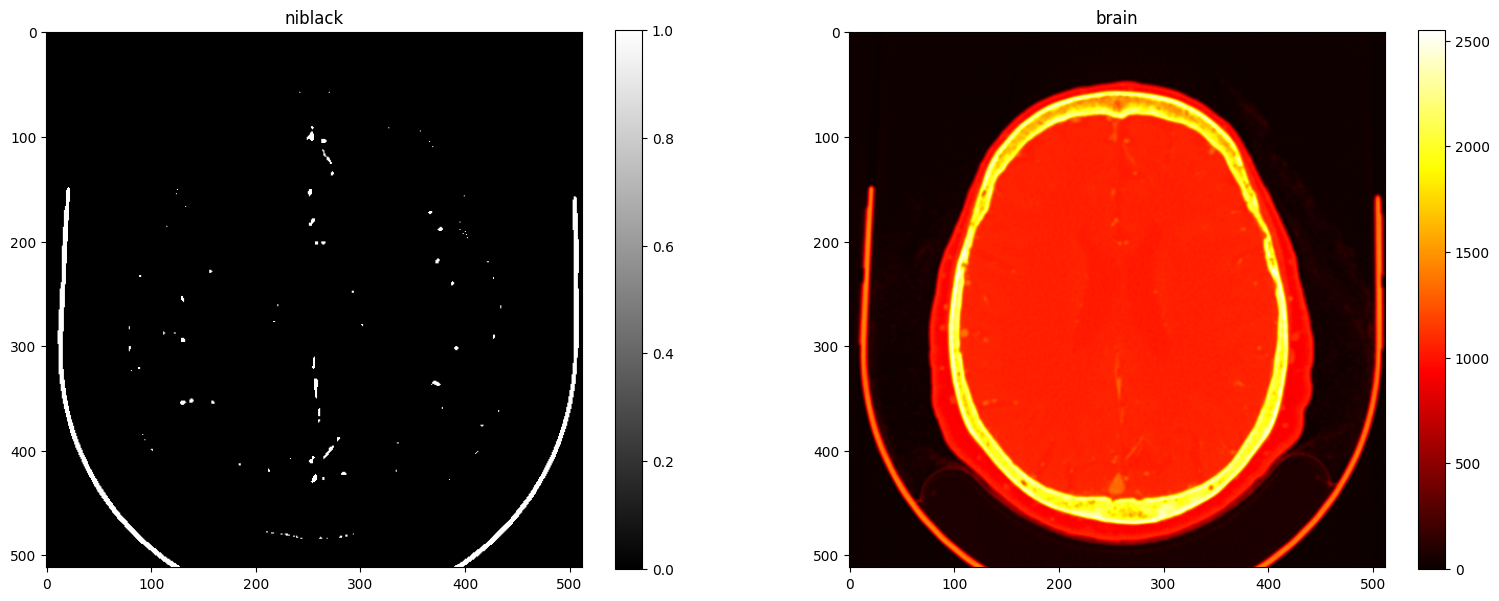

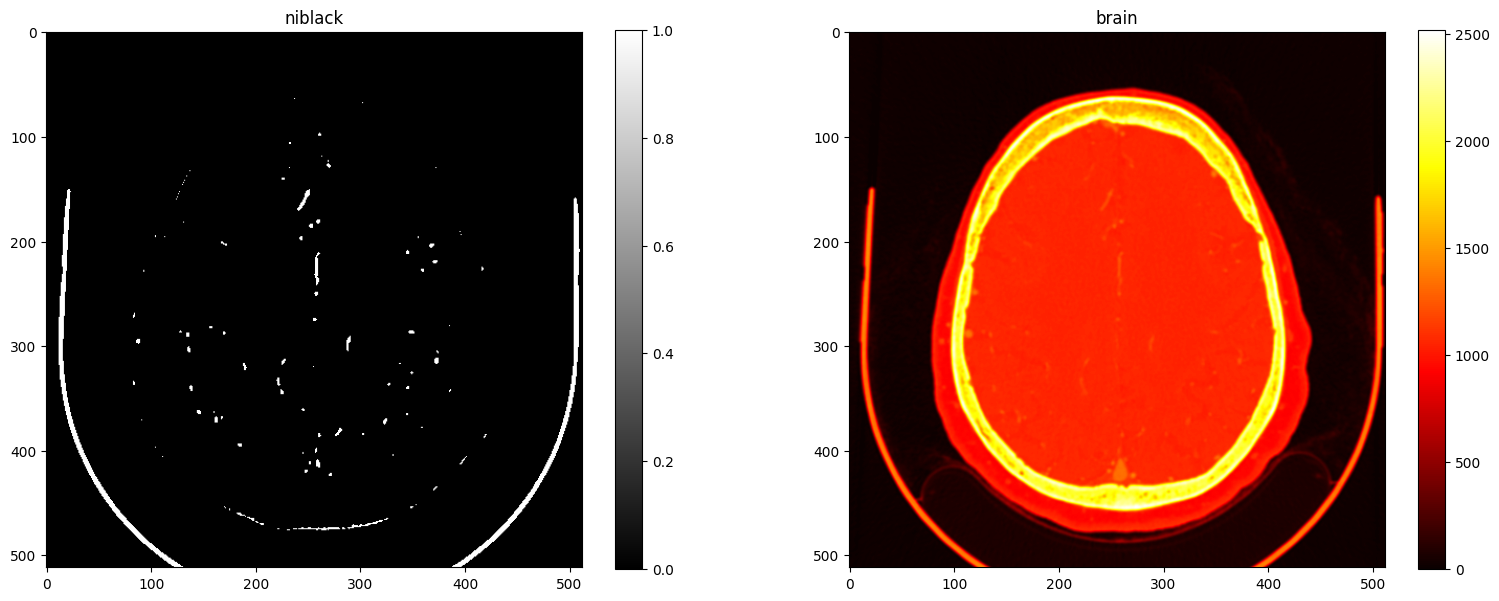

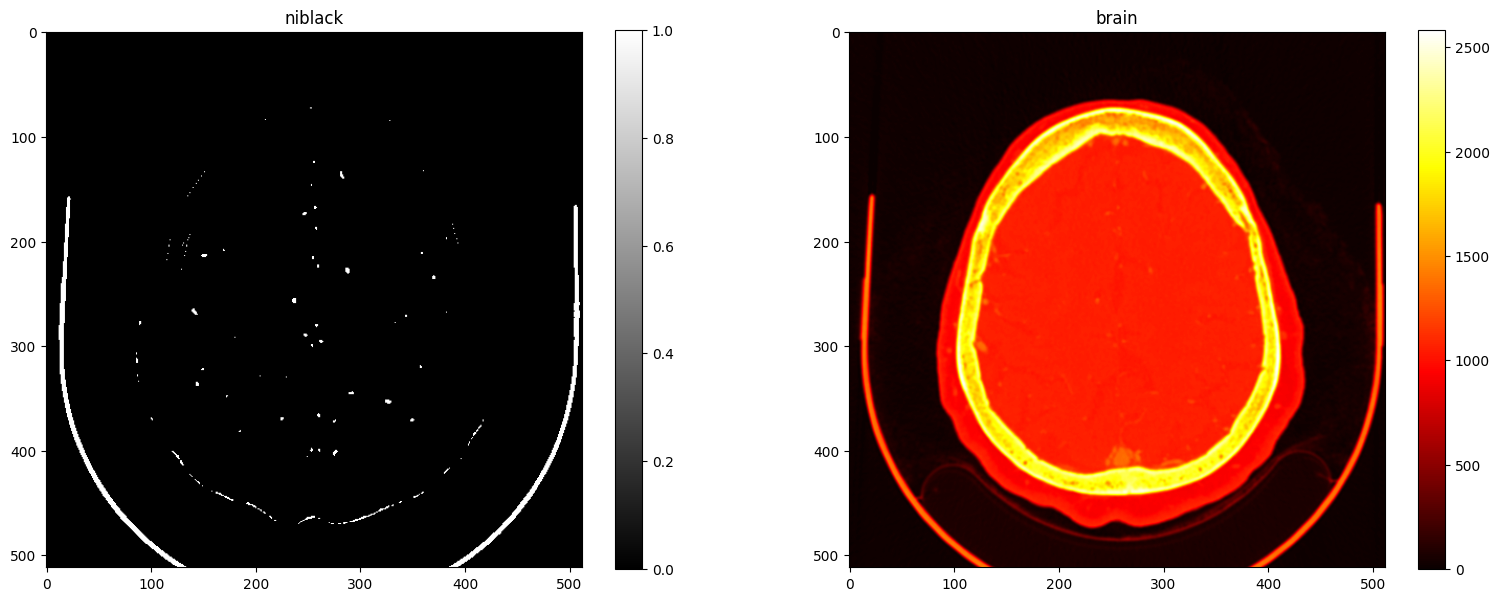

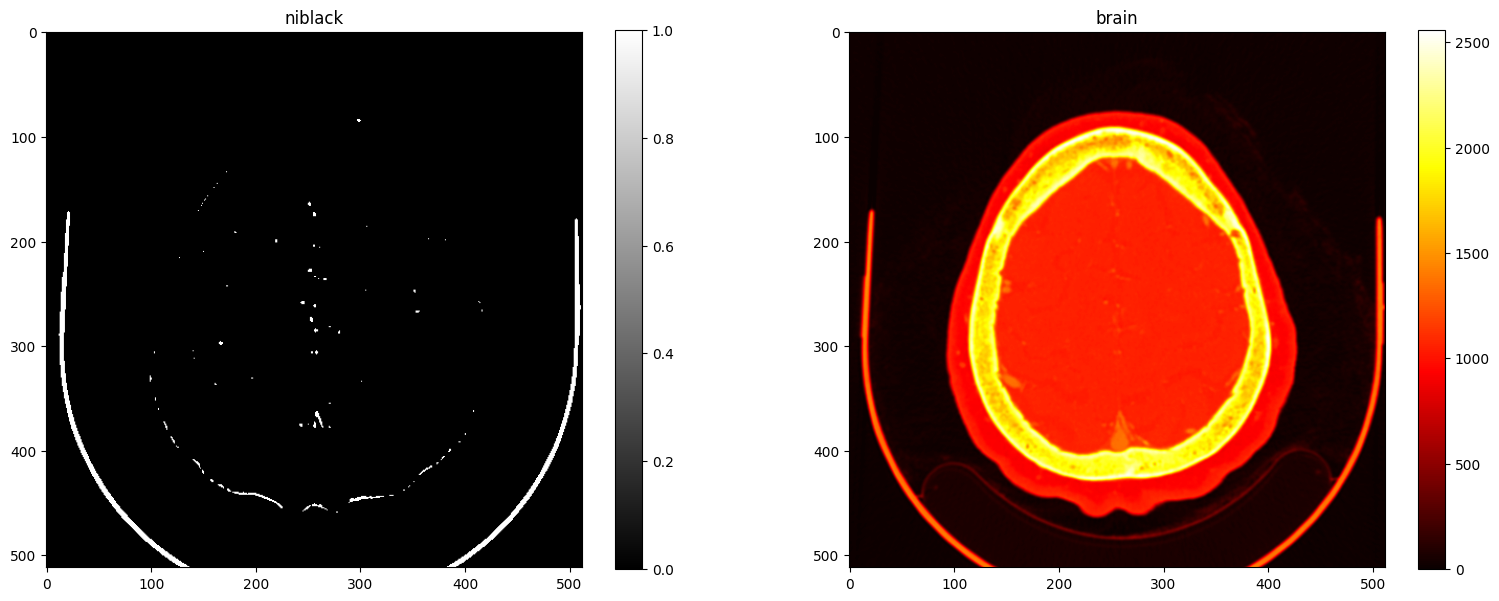

In [18]:
for idx in range(11, 300, 20):    
    SHOW_SLICE = idx

    fig, ax = plt.subplots(1, 2, figsize=(19, 7))    
    print_img(bin_vol, ax[0], 'niblack', cmap='gray')    
    print_img(brain_vol, ax[1], 'brain')  

In [19]:
data_dir = "seg_data/CT_S5020"
if not os.path.exists(data_dir):
    os.mkdir(data_dir)

#path_to_save_brain = data_dir + '/nitr1.nii.gz'
path_to_save_seg = data_dir + '/seg_nitr.nii.gz'

#save_vol_as_nii(brain_vol, vox_size2affine(vox_size), path_to_save_brain)
save_vol_as_nii(bin_vol, vox_size2affine(vox_size), path_to_save_seg)

#save_vol_as_nii(brain_vol, brain_file.affine, path_to_save_brain)
#save_vol_as_nii(bin_vol, brain_file.affine, path_to_save_seg)